# Inject missingness into the (static) dataset
Insert missingness into a dataset and save the corresponding ground truth m_graph and missingness model parameters. 
We use an AFAAgent that is based on a propensity score model to model the desired missingness and sample from it. 

__Note__: Only suitable for fully observed datasets where we want to test what happens under missingness. If your dataset already has missingness, please run `preparation03_missingness_assumptions` instead to define what you know about the missing data process. 

In [1]:
%load_ext autoreload
%autoreload 2

### Define paths 

In [2]:
from afa.configurations.utils_static import specify_default_paths_static
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MNAR_1'

# original data paths
paths_gt = specify_default_paths_static(dataset_name = dataset_name , miss_scenario = None) 

# new missing data paths
paths_miss = specify_default_paths_static(dataset_name = dataset_name , miss_scenario = miss_scenario) 

# save miss model files also in ground truth folder
m_graph_adj_gt_file     = paths_miss['data_dir']  + 'm_graphs/'  + 'ground_truth/' + 'm_graph_adjacencies.csv'
ps_model_weights_gt_file   = paths_miss['data_dir']  + 'm_graphs/'  + 'ground_truth/' + 'weights.csv'

## Load dataset without missingness 
At first, we want to load the dataset

Includes loading: 
- superfeature mapping
- problem
- afa_problem 

In [3]:
from afa.data_modelling.datasets.data_loader.data_loader_static import DataLoader_static

2023-02-19 00:14:20.330022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 00:14:20.463853: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-19 00:14:20.463872: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-19 00:14:21.098204: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
# load dataset 
data_loader = DataLoader_static( data_file                  = paths_gt['data_file'],
                                 superfeature_mapping_file  = paths_gt['superfeature_mapping_file'],
                                 problem_file               = paths_gt['problem_file'],
                                 afa_problem_files          = paths_gt['afa_problem_files'],
                                 folds_file                 = paths_gt['folds_file'])
dataset = data_loader.load() 

## Define agent to induce missingness
Here we use an AFAMechanismAgent (which uses PropensityScoreModel). 
This requires defining:
- an m_graph (through an adjacency matrix) 
- weights for a logistic regression model / constant model that defines the propensity score 

### Define missing data_graph and ps_model weights

#### Option 1: Create corresponding files directly as .csv file
__m-graph__:  
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: name of the features and then name of the superR
- entry(i,j) = 1  
    if node of index i has an arrow to node of column j 
    
__ps_model_weights__: 
Fill a .csv file containing the edges in the m_graph
- column_names: name of the superfeature missingness indicators (superR) with format 'R_' + superfeature_name
- row_names: 
    - row 1: bias 
    - other rows: names of the parents 
        - entry(i,j) = 1  
            linear weight of parent on superR

#### Option 2: Define here and save
Define the adjacency matrix of the m_graph and the weights using a pandas df

In [5]:
from afa.data_modelling.missingness.missing_data_graph.utils import save_m_graph_adjacency_matrix
import pandas as pd
# missing data graph
m_graph_adj = pd.DataFrame([[1, 1], [0, 0], [0, 0], [0, 0], [0, 0]], 
                            index   = ['X0', 'X1', 'X2', 'X3' , 'R_superX0'], 
                            columns = ['R_superX1', 'R_superX2'])

save_m_graph_adjacency_matrix( m_graph_adj ,  m_graph_adj_file = m_graph_adj_gt_file   ) 


In [6]:
from afa.data_modelling.missingness.propensity_scores.utils import save_logistic_regression_ps_model_weights, load_logistic_regression_ps_model_weights
import numpy as np 
# weights for ps model 
weights_df  = pd.DataFrame( [[-3, -3],[2, 2],[np.nan, np.nan],[np.nan, np.nan],[np.nan, np.nan]], 
                            index   = ['bias', 'X0', 'X1', 'X2', 'X3'], 
                            columns = ['R_superX1', 'R_superX2'])
save_logistic_regression_ps_model_weights( weights_df = weights_df,  ps_model_weights_file = ps_model_weights_gt_file) 
weights_df

,R_superX1,R_superX2
bias,-3.0,-3.0
X0,2.0,2.0
X1,NaN,NaN
X2,NaN,NaN
X3,NaN,NaN


#### Option 3 (not recommended): Prepared m_graphs and weights 
Lastly, for specific datasets, the creation can be automatically stored using hard-coded specifications. 

In [7]:
# PROBLEM: THE FILES HERE ARE WRONG
from afa.configurations.data_settings.define_data_settings_static import generate_m_graphs_and_weights_static
m_graph_adj, weights_df = generate_m_graphs_and_weights_static( dataset_name , miss_scenario ,  data_dir = paths_miss['data_dir']  )

In [8]:
weights_df

,R_superX1,R_superX2
bias,0.7,-2.0
X0,NaN,NaN
X1,NaN,2.0
X2,NaN,NaN
X3,NaN,NaN


### Initialize a Agent (using PropensityScoreModel)

In [9]:
from afa.data_modelling.missingness.missing_data_graph.utils import load_m_graph_adjacency_matrix
from afa.data_modelling.missingness.missing_data_graph.missing_data_graph_static import MissingDataGraph_static
from afa.data_modelling.models.static_models.joint_models.utils import load_joint_model_weights_static
from afa.data_modelling.missingness.propensity_scores.propensity_score_model_static import PropensityScoreModel_static
from afa.afa_models.afa_agents.afa_mechanism_agents.afa_mechanism_agent_static import AFAMechanismAgent_static

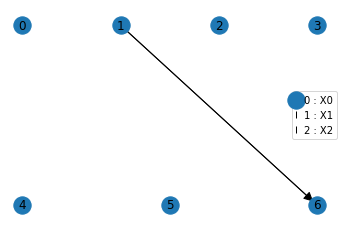

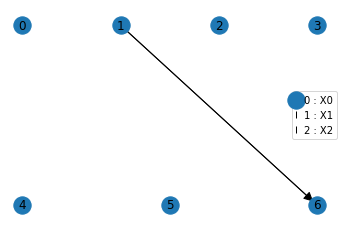

In [10]:
# 1. load m_graph 
m_graph_adj = load_m_graph_adjacency_matrix( m_graph_adj_file = m_graph_adj_gt_file )
m_graph     = MissingDataGraph_static(   m_graph_adj  = m_graph_adj ) 

# visualize
m_graph.plot() 

In [11]:
# 2. load weights
weights_df = load_logistic_regression_ps_model_weights( ps_model_weights_file = ps_model_weights_gt_file) 

# 3. initialize params
ps_model_params = {}
ps_model_params['base_model_params'] = {  'base_model_type': 'ann',
                                          'units': 1 ,
                                          'layers': 1,
                                          'learning_rate': 0.01,
                                          'epochs': 100,
                                          'checkpoint_dir': '',
                                          'gt_weights': weights_df}

# 4. init ps model
ps_model_name = 'ps_model_gt'
ps_model = PropensityScoreModel_static( name            = ps_model_name, 
                                        m_graph         = m_graph, 
                                        feature_name    = dataset.feature_name,
                                        target_superfeature_names    = dataset.afa_problem.target_superfeature_names,
                                        model_params = ps_model_params ) 

Change base_model to constant
Set weight for constant model ...


2023-02-19 00:14:26.659070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-19 00:14:26.659194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-19 00:14:26.659260: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-19 00:14:26.659314: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-19 00:14:26.659367: W tensorf

1/1 [==============================] - 1s 509ms/step - loss: 0.6931 - binary_accuracy: 1.0000
Set weights for ann ...


In [12]:
afa_agent = AFAMechanismAgent_static(  name      = miss_scenario + '_agent',
                                       ps_model  = ps_model 
                                 )

## Create new dataset using the defined agent

Run the agent as an afa agent over the dataset to create an afa_dataset. Then create a new regular dataset out of it

In [13]:
from afa.afa_datasets.afa_dataset_static import AFADataset_static 

In [14]:
afa_results = afa_agent.predict(dataset, ids = None, fold = None, split = None,  n_samples = 1) 

# create an afa_dataset out of the generated afa_results
afa_dataset = AFADataset_static(  dataset = dataset, model = afa_agent, results = afa_results) 

# check retrieving data 
data = afa_dataset.get_data( fold = None, split = None, n_samples = 1) 

4/4 [==============================] - 0s 2ms/step


In [15]:
dataset_new =  afa_dataset.create_new_dataset()

## Visualize newly created missingness 

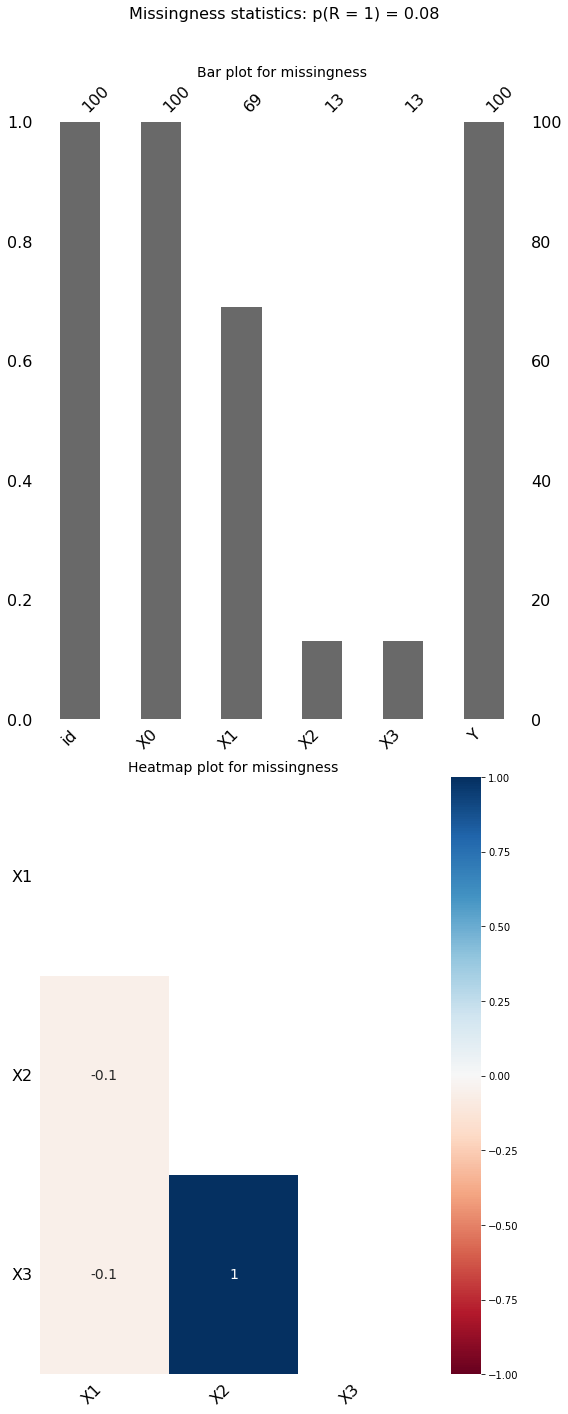

In [16]:
fig = dataset_new.plot_missingness_stats()

## Add the ground truth propensity score to the dataset

For comparison reasons we might be interested in the ground truth propensity score and add it back to dataset_new 

In [17]:
from afa.data_modelling.missingness.missingness_model import MissingnessModel

In [18]:
# compute ps values
ps_values, ps_values_1 = ps_model.predict(dataset_new)

4/4 [==============================] - 0s 1ms/step


In [19]:
# init miss_model in dataset
miss_model = MissingnessModel(m_graph)
dataset_new.miss_model = miss_model 

In [20]:
# add to dataset
dataset_new.miss_model.add_ps_values( ps_model_name , 
                                      ps_values = ps_values, 
                                      ps_values_1 = ps_values_1 )

## Save the new dataset

In [27]:
dataset_new.save( data_dir = paths_miss['data_dir'], 
                  dataset_name = dataset_name + '_' + miss_scenario, 
                  save_folds = True) 

In [25]:
dataset_new.miss_model.save(paths_miss['data_dir'])

## Reporting: summarize the whole dataset (with missingness) 
Store information in reports folder in latex / markdown format.

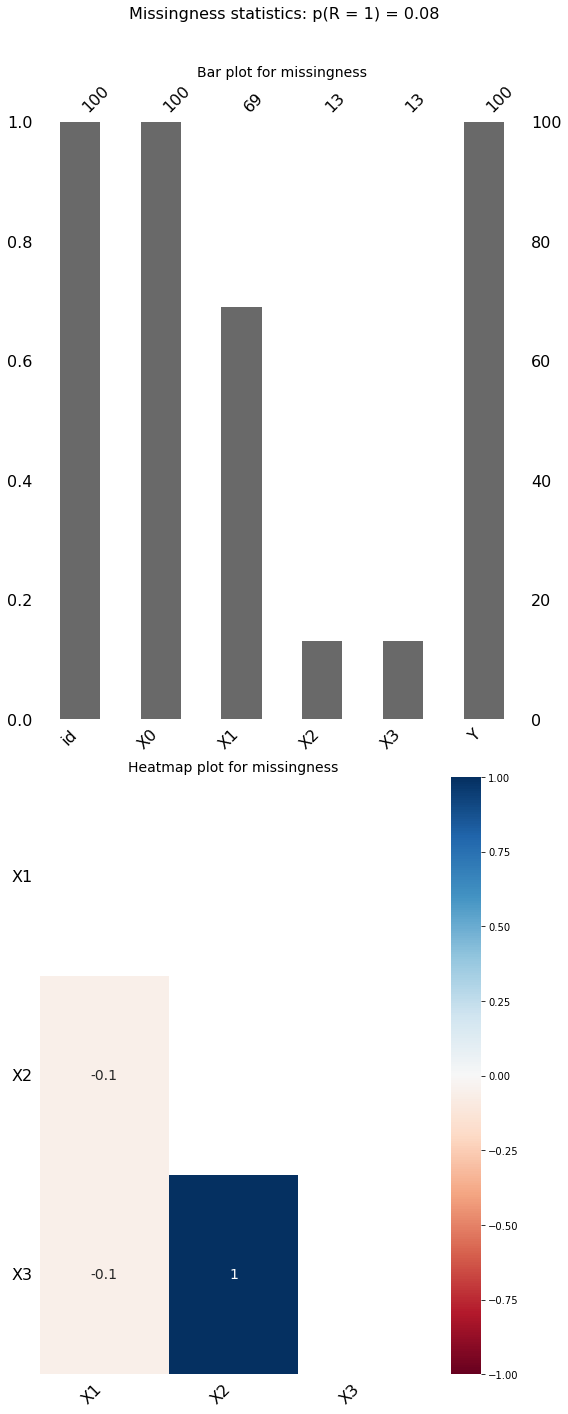

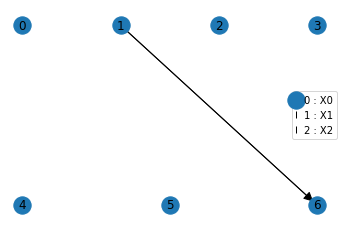

In [22]:
# reporting
explanation_file = paths_miss['data_dir'] + 'dataset_report'
dataset_new.explain(file=  explanation_file + '.md', format = 'markdown')
# dataset_new.explain(file=  explanation_file + '.tex', format = 'latex')